### Implementation of a GMM using the EM algorithm

In [1]:
import numpy as np
import pandas as pd
from multipledispatch import dispatch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from scipy.stats import multivariate_normal
from load_datasets import load_dataset

In [2]:
# p. 138-141
# https://cs229.stanford.edu/lectures-spring2022/main_notes.pdf

class GMM:
    def __init__(self,
                 n_components: int,
                 tol: float = 1e-3,
                 max_iter: int = 239,
                 verbose: int = 1):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.verbose = verbose

    def fit(self, X: np.ndarray, y: np.ndarray = None):
        """
        Fit the GMM model using the Expectation-Maximization algorithm.
        If targets are not passed, it does iterations until convergence is reached.
        Otherwise, it perform initial approximation.
        If targets are passed partly (semi-supervised learning) it proceeds with EM algorithm.
        """

        if y is not None:
            if self.verbose:
                print("Supervised learning...")

            X_labeled = X[~np.isnan(y)]
            n_samples, n_features = X_labeled.shape
            # Initialize the parameters (means, covariances, and weights) with zeros
            self.weights = np.zeros(self.n_components)  # Mixing coefficients
            self.means = np.zeros((self.n_components, n_features))  # Means
            self.covariances = np.zeros((self.n_components, n_features, n_features))  # Covariances

            # Compute the parameters (means, covariances, and weights)
            for k in range(self.n_components):
                # Extract the points belonging to class k
                X_k = X[y == k]
                self.weights[k] = len(X_k) / n_samples  # Mixing coefficient is the fraction of data points from class k
                self.means[k] = np.mean(X_k, axis=0)  # Mean of points in class k
                self.covariances[k] = np.cov(X_k, rowvar=False)  # Covariance of points in class k

            if X_labeled.shape[0] == X.shape[0]:  # Each sample is labeled
                return self
            # If some labels aren't labeled, proceed with EM algorithm as if no sample is labeled.

        else:
            n_samples, n_features = X.shape
            # Initialize mean, covariance and weight parameters
            self.weights = np.ones(self.n_components) / self.n_components  # (π - mixing coefficients)
            self.means = np.random.rand(self.n_components, n_features)  # (μ)
            self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])  # (Σ)

        if self.verbose:
            print("Unsupervised learning...")

        log_likelihood_old = 0
        for iteration in range(self.max_iter):
            # E-step: Calculate responsibilities
            if y is None:
                responsibilities = self._E_step(X)
            else:
                responsibilities = self._E_step(X, y)

            # M-step: Update parameters
            self._M_step(X, responsibilities)

            # Check convergence
            log_likelihood_new = self._compute_log_likelihood(X)
            if np.abs(log_likelihood_new - log_likelihood_old) < self.tol:
                if self.verbose:
                    print(f"Converged after {iteration+1} iterations.")
                break
            log_likelihood_old = log_likelihood_new

        return self

    # Unsupervised version of EM algorithm
    @dispatch(np.ndarray)
    def _E_step(self, X: np.ndarray):
        """
        E-step (no labels provided): Calculate the responsibility of each Gaussian for each data point.
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k], allow_singular=True)

        # Normalize the responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        return responsibilities

    # Semi-supervised version of EM algorithm
    @dispatch(np.ndarray, np.ndarray)
    def _E_step(self, X: np.ndarray, y: np.ndarray):
        """
        E-step (some labels provided): Calculate the responsibility of each Gaussian for each data point.
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        # Iterate over all data points
        for i in range(n_samples):
            if not np.isnan(y[i]):  # If the label is known
                k = int(y[i])  # The label corresponds to the Gaussian component
                responsibilities[i, k] = 1  # The responsibility of the true class is 1
            else:
                # If the label is unknown, the standard EM approach is used
                for k in range(self.n_components):
                    responsibilities[i, k] = self.weights[k] * multivariate_normal.pdf(X[i], mean=self.means[k], cov=self.covariances[k], allow_singular=True)
        
        # Normalize the responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        return responsibilities
    
    def _M_step(self, X: np.ndarray, responsibilities: np.ndarray):
        """
        M-step: Update the parameters of the GMM.
        """
        n_samples = X.shape[0]
        S_k = responsibilities.sum(axis=0)  # Sum of responsibilities for each component
        # Update weights
        self.weights = S_k / n_samples

        # Update means
        self.means = (responsibilities.T @ X) / S_k[:, np.newaxis]

        # Update covariances
        for k in range(self.n_components):
            X_centered = X - self.means[k]
            self.covariances[k] = (responsibilities[:, k] * X_centered.T @ X_centered) / S_k[k]

    def _compute_log_likelihood(self, X: np.ndarray):
        log_likelihood = 0
        for k in range(self.n_components):
            log_likelihood += self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k], allow_singular=True)
        
        return np.sum(np.log(log_likelihood))

    def predict(self, X: np.ndarray):
        responsibilities = self._E_step(X)
        return np.argmax(responsibilities, axis=1)

In [3]:
# X, y = load_dataset["breast_cancer"](return_X_y=True)
# X = pd.DataFrame(X)
# X = X.select_dtypes(include='number')  # Brute method (ignoring categorical features) is used for simplicity
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Fit the GMM model
# gmm = GMM(n_components=len(np.unique(y)))
# gmm.fit(X)

# # Predict the labels for the dataset
# labels = gmm.predict(X)

## Synthetic 2D dataset to verify correctness of the implementation

In [4]:
n_components = 5
X, y = make_blobs(n_samples=500, centers=n_components, cluster_std=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Supervised learning

Supervised learning...


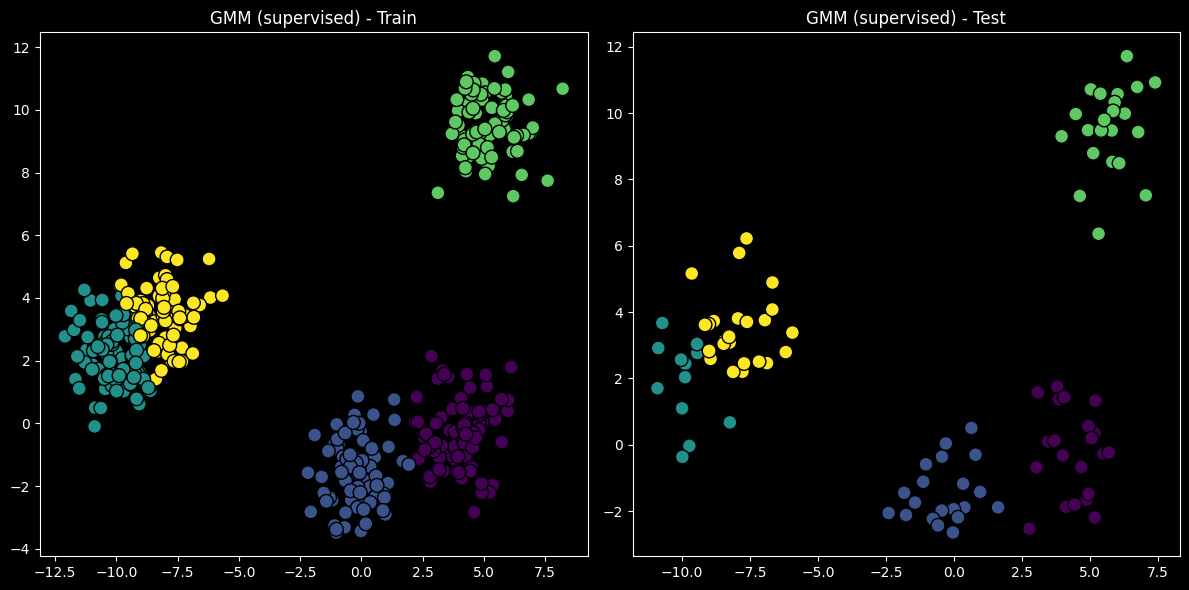

In [5]:
gmm = GMM(n_components=n_components, max_iter=1000)
# Fit with labels, make predictions
gmm.fit(X_train, y_train)
labels_train = gmm.predict(X_train)
labels_test = gmm.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(X_train[:, 0], X_train[:, 1], c=labels_train, cmap='viridis', s=100, edgecolors='k')
axs[0].set_title("GMM (supervised) - Train")
axs[1].scatter(X_test[:, 0], X_test[:, 1], c=labels_test, cmap='viridis', s=100, edgecolors='k')
axs[1].set_title("GMM (supervised) - Test")

plt.tight_layout()
plt.show()

### Unsupervised learning

Unsupervised learning...
Converged after 81 iterations.


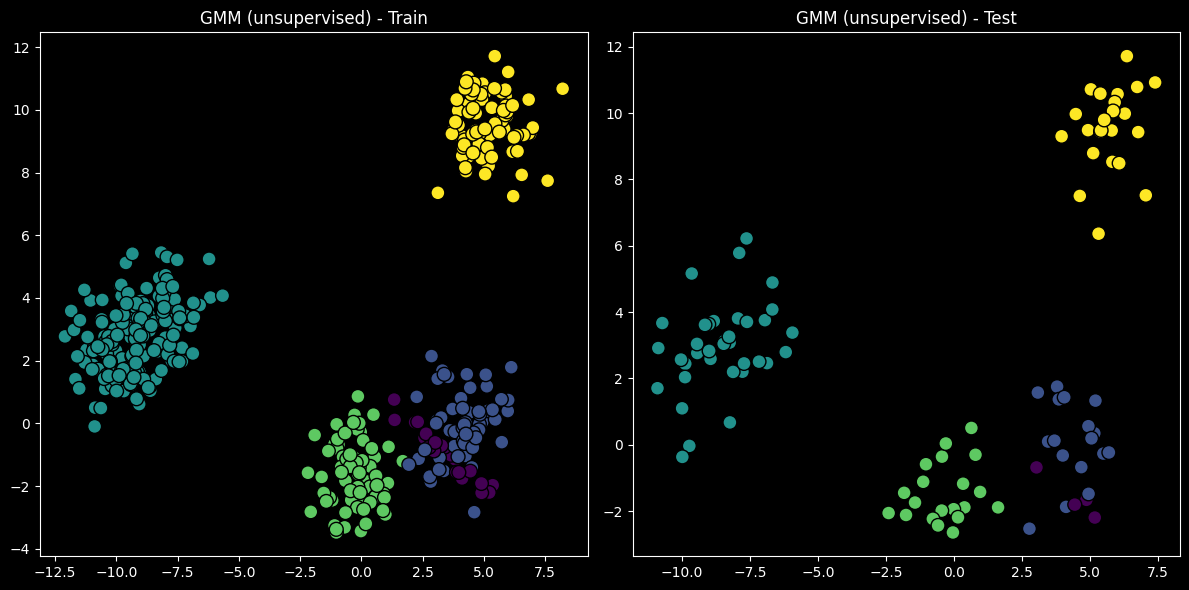

In [6]:
# Fit without labels, make predictions
gmm = GMM(n_components=n_components, max_iter=1000)
gmm.fit(X_train)
labels_train = gmm.predict(X_train)
labels_test = gmm.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(X_train[:, 0], X_train[:, 1], c=labels_train, cmap='viridis', s=100, edgecolors='k')
axs[0].set_title("GMM (unsupervised) - Train")
axs[1].scatter(X_test[:, 0], X_test[:, 1], c=labels_test, cmap='viridis', s=100, edgecolors='k')
axs[1].set_title("GMM (unsupervised) - Test")

plt.tight_layout()
plt.show()

# Partially supervised:

- Use labeled data to compute the first approximation of the parameters, and then fit the model as if the data were unlabeled.

In [7]:
no_label_mask = np.random.choice(y_train.shape[0], replace=False, size=100)

y_train_masked = np.array(y_train, copy=True, dtype=float)
y_train_masked[no_label_mask] = np.nan

Supervised learning...
Unsupervised learning...
Converged after 4 iterations.


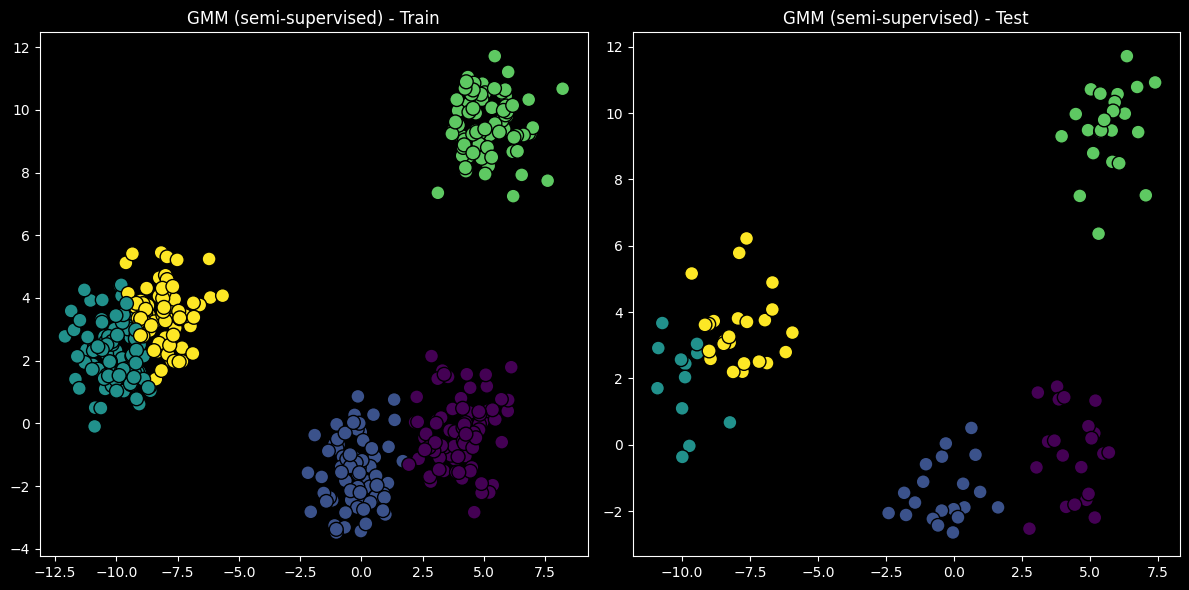

In [8]:
gmm = GMM(n_components=n_components, max_iter=1000)
gmm.fit(X_train, y_train_masked)

labels_train = gmm.predict(X_train)
labels_test = gmm.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(X_train[:, 0], X_train[:, 1], c=labels_train, cmap='viridis', s=100, edgecolors='k')
axs[0].set_title("GMM (semi-supervised) - Train")
axs[1].scatter(X_test[:, 0], X_test[:, 1], c=labels_test, cmap='viridis', s=100, edgecolors='k')
axs[1].set_title("GMM (semi-supervised) - Test")

plt.tight_layout()
plt.show()